`Team 16 Dự đoán giá vàng bạc bạch kim bằng thuật toán RNN
`

In [23]:
#Cài đặt thư viện 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})
import numpy as np 
import pandas as pd 
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error
import statsmodels.api as sm
from IPython.display import display, Markdown
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [24]:

df = pd.read_csv('../SilverData.csv', parse_dates=True,)
df

,Ngày,Lần cuối,Mở,Cao,Thấp,KL
0,21/5/2018,16.520,16.430,16.535,16.280,63.89K
1,22/5/2018,16.575,16.530,16.700,16.465,73.53K
2,23/5/2018,16.405,16.555,16.600,16.330,89.46K
3,24/5/2018,16.687,16.475,16.715,16.420,91.02K
4,25/5/2018,16.546,16.690,16.740,16.500,72.71K
...,...,...,...,...,...,...
1275,15/5/2023,24.175,24.030,24.270,23.945,0.17K
1276,16/5/2023,23.783,24.115,24.115,23.710,0.18K
1277,17/5/2023,23.789,23.830,23.940,23.650,0.18K
1278,18/5/2023,23.523,23.840,23.840,23.380,0.35K


In [25]:
#Xem các dữ liệu cơ bản của cảc thuộc tính
df.describe()

,Lần cuối,Mở,Cao,Thấp
count,1280.000000,1280.000000,1280.000000,1280.000000
mean,20.414323,20.428459,20.685217,20.134988
std,4.325552,4.335049,4.437082,4.203927
min,11.772000,11.975000,12.330000,11.640000
25%,16.223000,16.252500,16.388750,16.080000
50%,20.350500,20.312500,20.762500,19.987500
75%,24.250750,24.251250,24.580000,23.872500
max,29.418000,29.235000,30.350000,28.155000


In [26]:
#Kiểm tra dữ liệu rỗng
df.isnull().sum()

Ngày         0
Lần cuối     0
Mở           0
Cao          0
Thấp         0
KL          28
dtype: int64

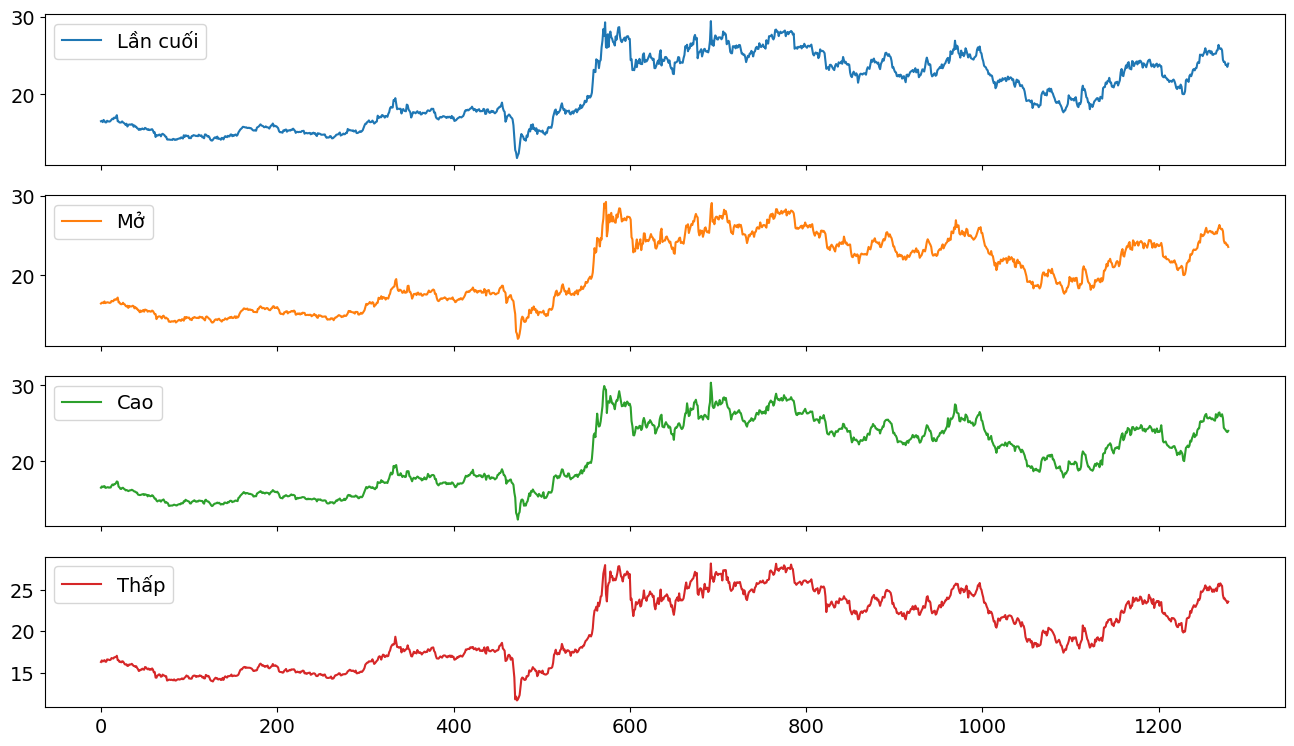

In [27]:
#Xem độ biến thiên của từng thuộc tính.
df.plot(legend=True,subplots=True, figsize = (16, 9))
plt.show()

In [28]:
#Chuyển dataset về cột Close để tiến hành tạo model
df = df[['Lần cuối']]
df

,Lần cuối
0,16.520
1,16.575
2,16.405
3,16.687
4,16.546
...,...
1275,24.175
1276,23.783
1277,23.789
1278,23.523


In [29]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [30]:
#Chia dữ liệu theo các tỷ lệ 7:2:1
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [31]:
#Tạo hàm create dataset
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX),np.array(dataY)

In [32]:
#Chia thành các tập X,y
time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
print(y_train)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)


[0.22894707 0.21789641 0.21545959 0.20571234 0.21404284 0.20701575
 0.21239941 0.21630965 0.21098266 0.21086932 0.22072991 0.21676301
 0.21058597 0.20661906 0.21098266 0.20452227 0.20588235 0.20922589
 0.21098266 0.20151876 0.1838377  0.1878046  0.1539159  0.16848011
 0.16388983 0.16609997 0.17154029 0.17074691 0.15895954 0.17335373
 0.17732064 0.17273036 0.16780007 0.15748612 0.15555933 0.13646152
 0.13447807 0.13646152 0.13425139 0.13362802 0.13408138 0.13260796
 0.14020175 0.13753825 0.13226794 0.13663153 0.13447807 0.13986173
 0.14110847 0.14411198 0.14303525 0.15147909 0.14632211 0.14269523
 0.16661    0.15499263 0.16553327 0.16422985 0.15969625 0.16303978
 0.14490536 0.14892894 0.14473535 0.16060297 0.1622464  0.16746005
 0.16598663 0.16383316 0.16048963 0.16309645 0.15952624 0.17120027
 0.16456987 0.16196305 0.16592996 0.15130908 0.15482262 0.14462201
 0.17278703 0.17148362 0.16541993 0.15703276 0.16094299 0.15272583
 0.1366882  0.12932109 0.12756432 0.133288   0.14348861 0.1501

In [33]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(20,activation='relu',return_sequences=True,input_shape=(time_step, 1)))
model.add(SimpleRNN(20,activation='relu',return_sequences=True))
model.add(SimpleRNN(20,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [34]:

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32,verbose=1)


Epoch 1/100


27/27 [==============================] - 3s 26ms/step - loss: 0.0206 - val_loss: 0.0055
Epoch 2/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 3/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 4/100
27/27 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 6/100
27/27 [==============================] - 0s 14ms/step - loss: 9.6157e-04 - val_loss: 9.9647e-04
Epoch 7/100
27/27 [==============================] - 0s 12ms/step - loss: 8.8013e-04 - val_loss: 8.0123e-04
Epoch 8/100
27/27 [==============================] - 0s 12ms/step - loss: 8.1777e-04 - val_loss: 7.3056e-04
Epoch 9/100
27/27 [==============================] - 0s 12ms/step - loss: 7.8358e-04 - val_loss: 0.0013
Epoch 10/100
27/27 [==============================] - 0s 12ms/step - loss: 8.9823e-0

In [35]:

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)


3/3 [==============================] - 0s 3ms/step


In [36]:

# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
y_test=scaler.inverse_transform(y_test.reshape(-1,1))
y_val=scaler.inverse_transform(y_val.reshape(-1,1))


In [37]:
# Đánh giá 
def deviation(test, pred):
  rmse= np.sqrt(mean_squared_error(test,pred))
  print(f"RMSE: {rmse:.2f}")
  mape= mean_absolute_percentage_error(test,pred)
  print(f"MAPE: {mape*100:.2f}%")
  mae = mean_absolute_error(test, pred)
  print(f"MAE: {mae:.2f}")

In [38]:
#Hàm visualize
def visualize(label ,pred, model_name):
  plt.figure(figsize=(12,8))
  plt.plot(label, label = 'Ground truth')
  plt.plot(pred, label='Predict')
  plt.title(model_name)
  plt.xlabel('Date')
  plt.ylabel('Closing Price')
  plt.legend()
  plt.show()

In [39]:

y_test2=scaler.inverse_transform(y_test.reshape(-1,1))
y_val2=scaler.inverse_transform(y_val.reshape(-1,1))

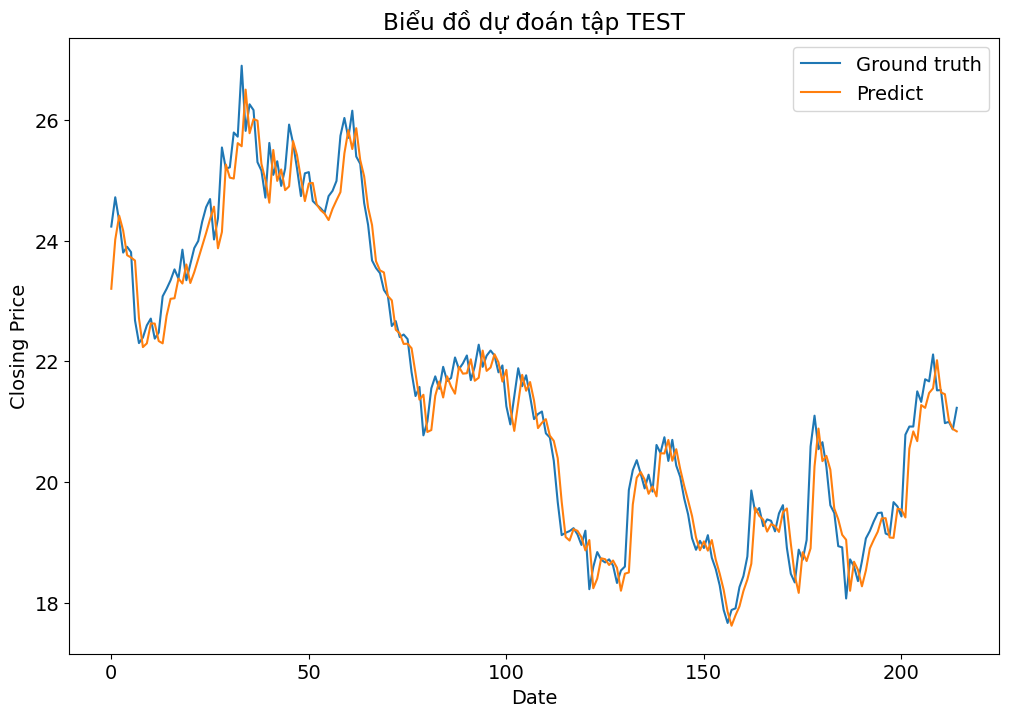

Đánh Giá tập TEST
RMSE: 0.45
MAPE: 1.57%
MAE: 0.34


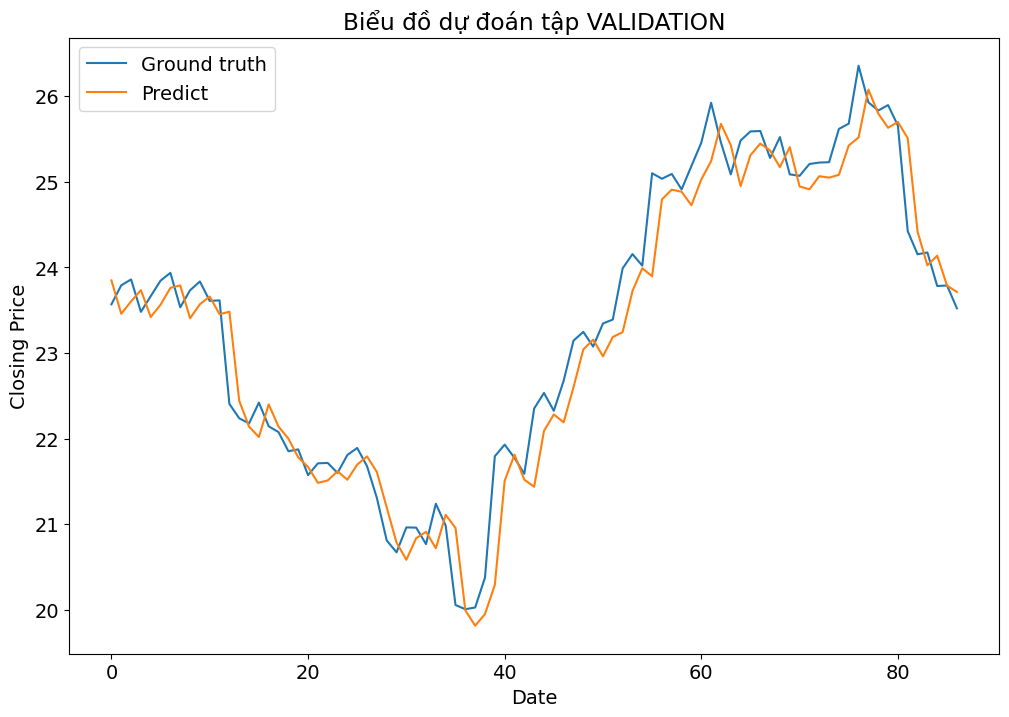

Đánh Giá tập VALIDATION
RMSE: 0.42
MAPE: 1.33%
MAE: 0.31


In [40]:
# visualize(y_train,y_pred_train,'Biểu đồ dự đoán tập TRAIN')
visualize(y_test,y_pred,'Biểu đồ dự đoán tập TEST')
print('Đánh Giá tập TEST')
deviation(y_test, y_pred)

visualize(y_val,y_pred_val,'Biểu đồ dự đoán tập VALIDATION')
print('Đánh Giá tập VALIDATION')
deviation(y_val, y_pred_val)

In [41]:

val_len=len(val_data)
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=val_len-60
i=0
while(i<30):
        
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.6791145]
69
1 day input [0.56318712 0.56347047 0.55684008 0.56874079 0.57338774 0.56131701
 0.54029242 0.51218406 0.50425026 0.52074124 0.5206279  0.50969058
 0.53643885 0.52204466 0.46934149 0.46656466 0.46769806 0.48753259
 0.56789074 0.57559787 0.56681401 0.55627338 0.59951264 0.60982659
 0.59798255 0.61787374 0.644452   0.65028902 0.64054177 0.65584268
 0.65844951 0.69233821 0.70180211 0.69415165 0.75535532 0.75172844
 0.75490196 0.74464468 0.76017228 0.77558654 0.80205146 0.77569988
 0.75461861 0.77705996 0.78306698 0.78335033 0.76549926 0.77932676
 0.75461861 0.75365522 0.76147569 0.76243908 0.76266576 0.78471042
 0.78822396 0.8265896  0.80233481 0.79689448 0.80052136 0.78692055
 0.71698969 0.70168877 0.70287884 0.68066417 0.68100419 0.66592996
 0.69001473 0.67911452]
1 day output [[0.66933596]]
2 day input [0.56347047 0.55684008 0.56874079 0.57338774 0.56131701 0.54029242
 0.51218406 0.50425026 0.52074124 0.5206279  0.50969058 0.53643885
 0.52204466 0.46934149 0.46656466 0.46

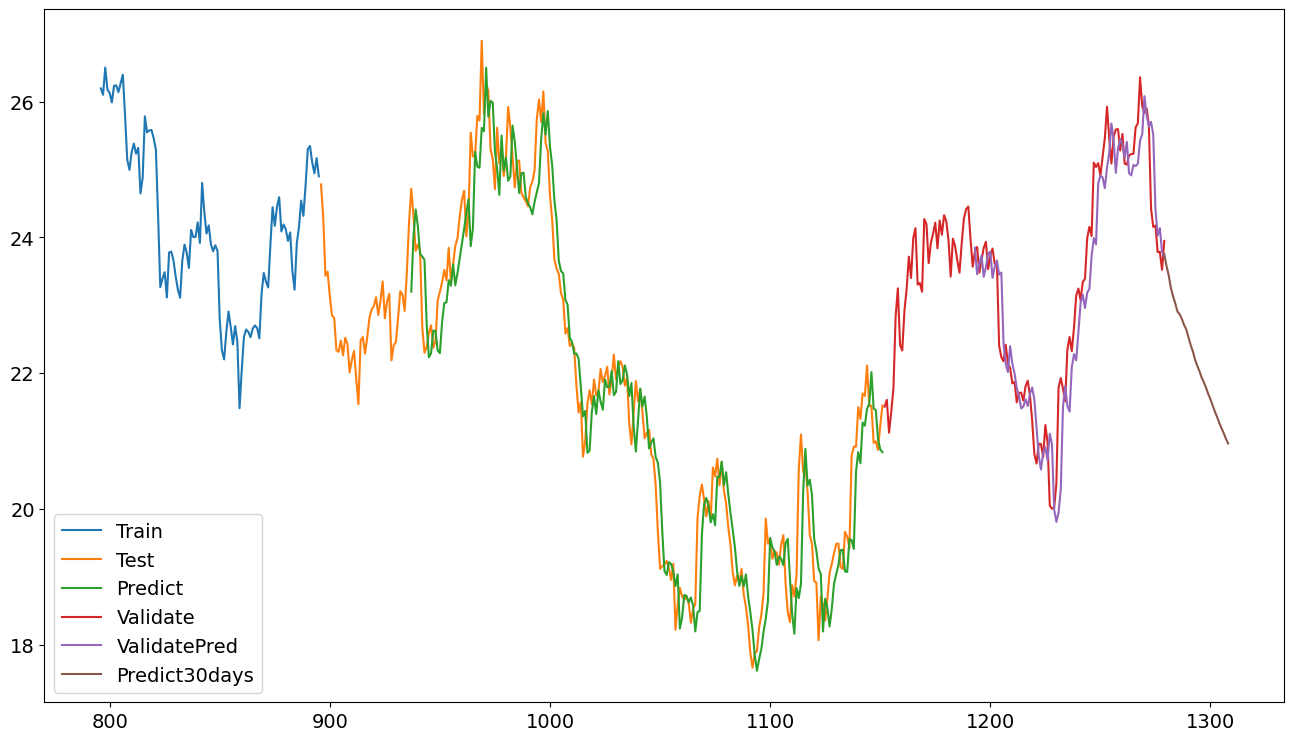

In [42]:
# Vẽ hình
plt.figure(figsize=(16,9))

train_data_index = pd.RangeIndex(start=train_size-100, stop=train_size, step=1)
plt.plot(train_data_index,scaler.inverse_transform(train_data[train_size-100:]))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+ 41, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

val_data_index = pd.RangeIndex(start=train_size + test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size + test_size+ 41, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)


prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()